# Decision Trees

In [32]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import cross_validation
from sklearn import tree as Tree
from sklearn import ensemble
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
import sklearn.tree
%matplotlib inline 

## Load in data

In [40]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/80_20_processed_data/new_master_8020_df.csv',index_col=0)

In [41]:
data.head(5)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision
0,10.0,0.0,8.0,0.0,-1.0,1.0,0.0,3.286,0.407,1.0,...,1.0,2.234,0.325,1.0,0.0,2.133,0.482,1.411,0.435,1.0
1,10.0,0.0,7.0,0.0,-2.0,1.0,1.0,2.405,0.463,1.0,...,0.0,2.133,0.482,1.0,0.0,1.411,0.435,2.169,0.395,0.0
2,9.0,1.0,6.0,0.0,-3.0,1.0,1.0,2.379,0.367,1.0,...,0.0,1.411,0.435,0.0,0.0,2.169,0.395,3.838,0.469,0.0
3,8.0,2.0,5.0,0.0,-4.0,1.0,1.0,2.234,0.325,1.0,...,0.0,2.169,0.395,0.0,0.0,3.838,0.469,1.846,0.378,1.0
4,8.0,2.0,5.0,0.0,1.0,1.0,0.0,2.133,0.482,1.0,...,0.0,3.838,0.469,1.0,1.0,1.846,0.378,1.527,0.416,1.0


In [42]:
data = data.drop('0_trialDuration',axis=1)
data.head(2)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Port,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision
0,10.0,0.0,8.0,0.0,-1.0,1.0,0.0,3.286,0.407,1.0,...,1.0,1.0,2.234,0.325,1.0,0.0,2.133,0.482,1.411,1.0
1,10.0,0.0,7.0,0.0,-2.0,1.0,1.0,2.405,0.463,1.0,...,1.0,0.0,2.133,0.482,1.0,0.0,1.411,0.435,2.169,0.0


In [43]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

# Change 'y' so that 1 corresponds to a switch, and 0 corresponds to no switch

In [44]:
y_diff = np.diff(y)
x = x[1:,:]
y = np.abs(y_diff)

print(x.shape)
print(y_diff.shape)

(20831, 26)
(20831,)


## Use only outcome features

In [45]:
data = data.iloc[1:,:]
data['Decision'] = y

outcome_features = ['Streak','5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Decision']

data_outcome = data[outcome_features]

x = data_outcome.iloc[:,:-1].values
y = data_outcome.iloc[:,-1].values

#uncomment if you want to run on all features
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [46]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [47]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 14581 | # switches: 1261 --> 8.6 percent
# test trials: 6250 | # switches: 524 --> 8.4 percent


# Decision Tree with all outcome features

In [120]:
tree = Tree.DecisionTreeClassifier(max_depth = 2,class_weight='balanced')
tree.fit(x_train,y_train)
y_predict = tree.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         4199.0         1527.0
True YES          66.0          458.0

F1: 0.365

Accuracy on class 0: 0.73
Accuracy on class 1: 0.87



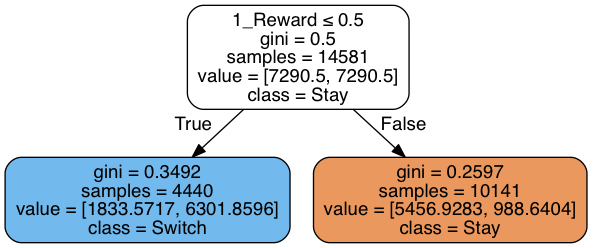

In [70]:
dot_data = Tree.export_graphviz(tree,out_file=None,
                     feature_names=data.columns.values[:-1],
                     class_names = ['Stay','Switch'],
                     filled=True,rounded=True,special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

This isn't sensitive to max_depth i.e. it does not improve for any number > 1. 

In [54]:
tree.feature_importances_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.04237534,  0.        ,
        0.        ,  0.        ,  0.87563932,  0.        ,  0.        ,
        0.08198534])

# Try boosting single feature decision trees

In [95]:
# boosting: many many weak classifiers (max_depth=1) refine themselves sequentially
# tree is the default the base classifier
estimator = ensemble.GradientBoostingClassifier(n_estimators=10, learning_rate=.001, max_depth=5, random_state=0)
estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         4232.0         1494.0
True YES          83.0          441.0

F1: 0.359

Accuracy on class 0: 0.74
Accuracy on class 1: 0.84



# Benchmark model --> what if we just predict the mouse switches every time it doesn't get a reward?

In [114]:
y_predict = (data['1_Reward'].values == 0).astype('int')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         3989.0         1737.0
True YES         370.0          154.0

F1: 0.128

Accuracy on class 0: 0.70
Accuracy on class 1: 0.29



/Users/shayneufeld/GitHub/mouse_bandit/support_functions.py:78: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20831 but corresponding boolean dimension is 6250
  acc_pos = np.mean(y_predict[y_test==1] == y_test[y_test==1])
/Users/shayneufeld/GitHub/mouse_bandit/support_functions.py:79: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20831 but corresponding boolean dimension is 6250
  acc_neg = np.mean(y_predict[y_test==0] == y_test[y_test==0])


In [ ]:
inds = np.arange(0,600,100)
plt.figure(figsize=(15,10))

for i,ind in enumerate(inds):
    
    plt.subplot(2,3,i+1)
    plt.plot(P,acc_cv[ind:ind+100,0],color='purple',label='switching accuracy')
    plt.plot(P,acc_cv[ind:ind+100,1],color='black',label='staying accuracy')
    plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
    plt.legend(loc='lower right',bbox_to_anchor=[0.5,0.3])
    plt.ylabel('Model accuracy')
    plt.xlabel('Switching class weight')
    plt.title('Decision Tree \nDepth: %.0f' % D[i])
plt.tight_layout()

In [ ]:
best_tree = Tree.DecisionTreeClassifier(max_depth=2,class_weight={0:0.10,1:0.9})
best_tree.fit(x_train,y_train)
y_predict = best_tree.predict(x_test)
acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test,confusion=False)